In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization import hist

In [4]:
results_path = Path("../data/results")

In [5]:
dfs = []

for result_path in results_path.iterdir():
    dfs.append(pd.read_parquet(result_path))

df = pd.concat(dfs)

In [6]:
display(df)

,step,f1_macro_test,experiment_name,run
0,0,0.388683,XRAY-64x64-REAL,1684942801
1,1,0.386457,XRAY-64x64-REAL,1684942801
2,2,0.387023,XRAY-64x64-REAL,1684942801
3,3,0.388702,XRAY-64x64-REAL,1684942801
4,4,0.387571,XRAY-64x64-REAL,1684942801
...,...,...,...,...
69036,1572,0.703197,XRAY-64x64-SYNTHETIC-UNBALANCED,1684959611
69037,1573,0.699393,XRAY-64x64-SYNTHETIC-UNBALANCED,1684959611
69038,1574,0.727458,XRAY-64x64-SYNTHETIC-UNBALANCED,1684959611
69039,1575,0.714417,XRAY-64x64-SYNTHETIC-UNBALANCED,1684959611


In [7]:
def get_max_f1_and_argmax(df):
    idxmax = df["f1_macro_test"].argmax()
    max = df["f1_macro_test"].values[idxmax]
    return idxmax, max

In [8]:
better_results = (
    df.groupby(["experiment_name", "run"])
    .apply(get_max_f1_and_argmax)
)

In [9]:
rdf = pd.DataFrame(better_results)
rdf[["converge_at", "f1"]] = rdf.loc[:, 0].tolist()
rdf = rdf.drop(columns=[0])
rdf = rdf.reset_index()

In [10]:
from astropy.stats import sigma_clip

In [11]:
display(rdf)

,experiment_name,run,converge_at,f1
0,XRAY-64x64-REAL,1684939675,555.0,0.792970
1,XRAY-64x64-REAL,1684939908,822.0,0.801793
2,XRAY-64x64-REAL,1684940178,556.0,0.802665
3,XRAY-64x64-REAL,1684940410,47.0,0.392086
4,XRAY-64x64-REAL,1684940569,980.0,0.782165
...,...,...,...,...
88,XRAY-64x64-SYNTHETIC-UNBALANCED,1684964766,864.0,0.820893
89,XRAY-64x64-SYNTHETIC-UNBALANCED,1684965045,858.0,0.805678
90,XRAY-64x64-SYNTHETIC-UNBALANCED,1684965323,841.0,0.793787
91,XRAY-64x64-SYNTHETIC-UNBALANCED,1684965595,827.0,0.815926


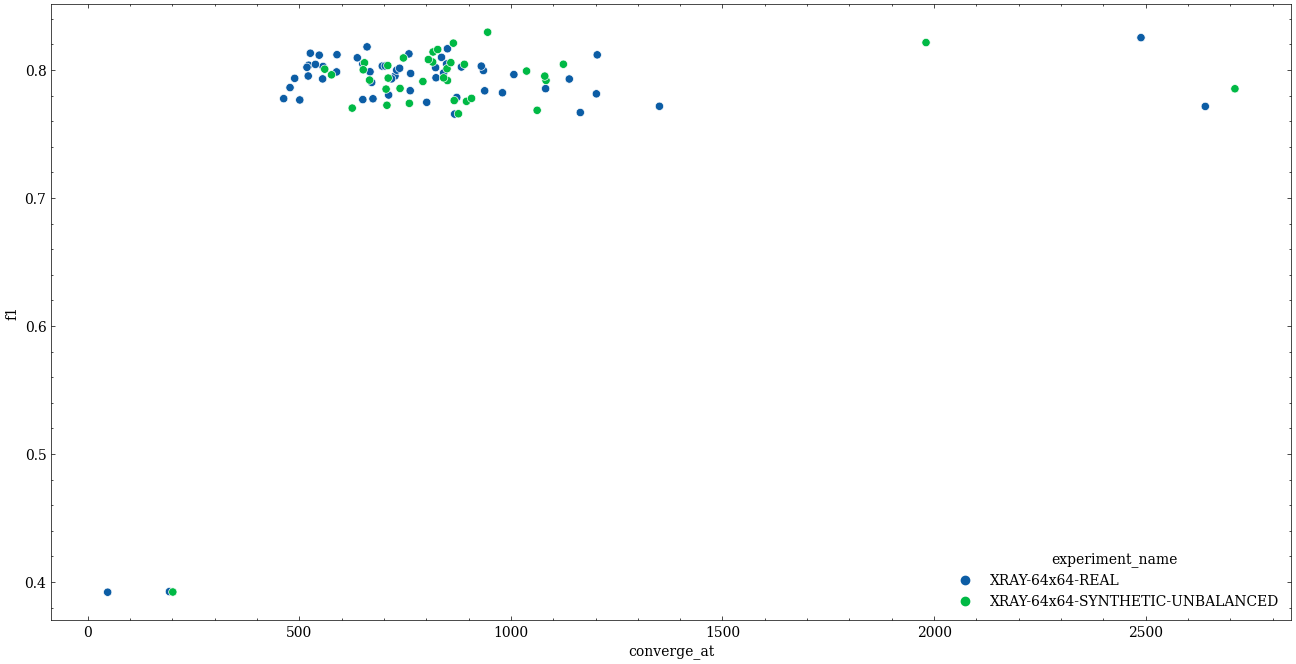

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=rdf, x="converge_at", y="f1", hue="experiment_name")
# plt.scatter(x=rdf["converge_at"], y=rdf["f1"])
plt.show()

In [12]:
rdf.groupby("experiment_name").describe()

converge_at                                  
                                      count        mean         std    min   
experiment_name                                                              
XRAY-64x64-REAL                        56.0  804.446429  416.384347   47.0  \
XRAY-64x64-SYNTHETIC-UNBALANCED        37.0  886.000000  402.680946  201.0   

                                                                 f1             
                                   25%    50%     75%     max count      mean   
experiment_name                                                                 
XRAY-64x64-REAL                  580.0  728.0  874.75  2641.0  56.0  0.780614  \
XRAY-64x64-SYNTHETIC-UNBALANCED  709.0  827.0  895.00  2711.0  37.0  0.784387   

                                                                          
                                      std       min       25%       50%   
experiment_name                                                           
XRAY-64x64-REAL                  0.076651  0.392086  0.781953  0.796795  \
XRAY-64x64-SYNTHETIC-UNBALANCED  0.068106  0.392243  0.785003  0.795143   

                                                     
                                      75%       max  
experiment_name                                      
XRAY-64x64-REAL                  0.803224  0.825204  
XRAY-64x64-SYNTHETIC-UNBALANCED  0.805550  0.829436

In [13]:
import scienceplots

plt.style.use(['science', 'no-latex'])

---
# Resultados F1

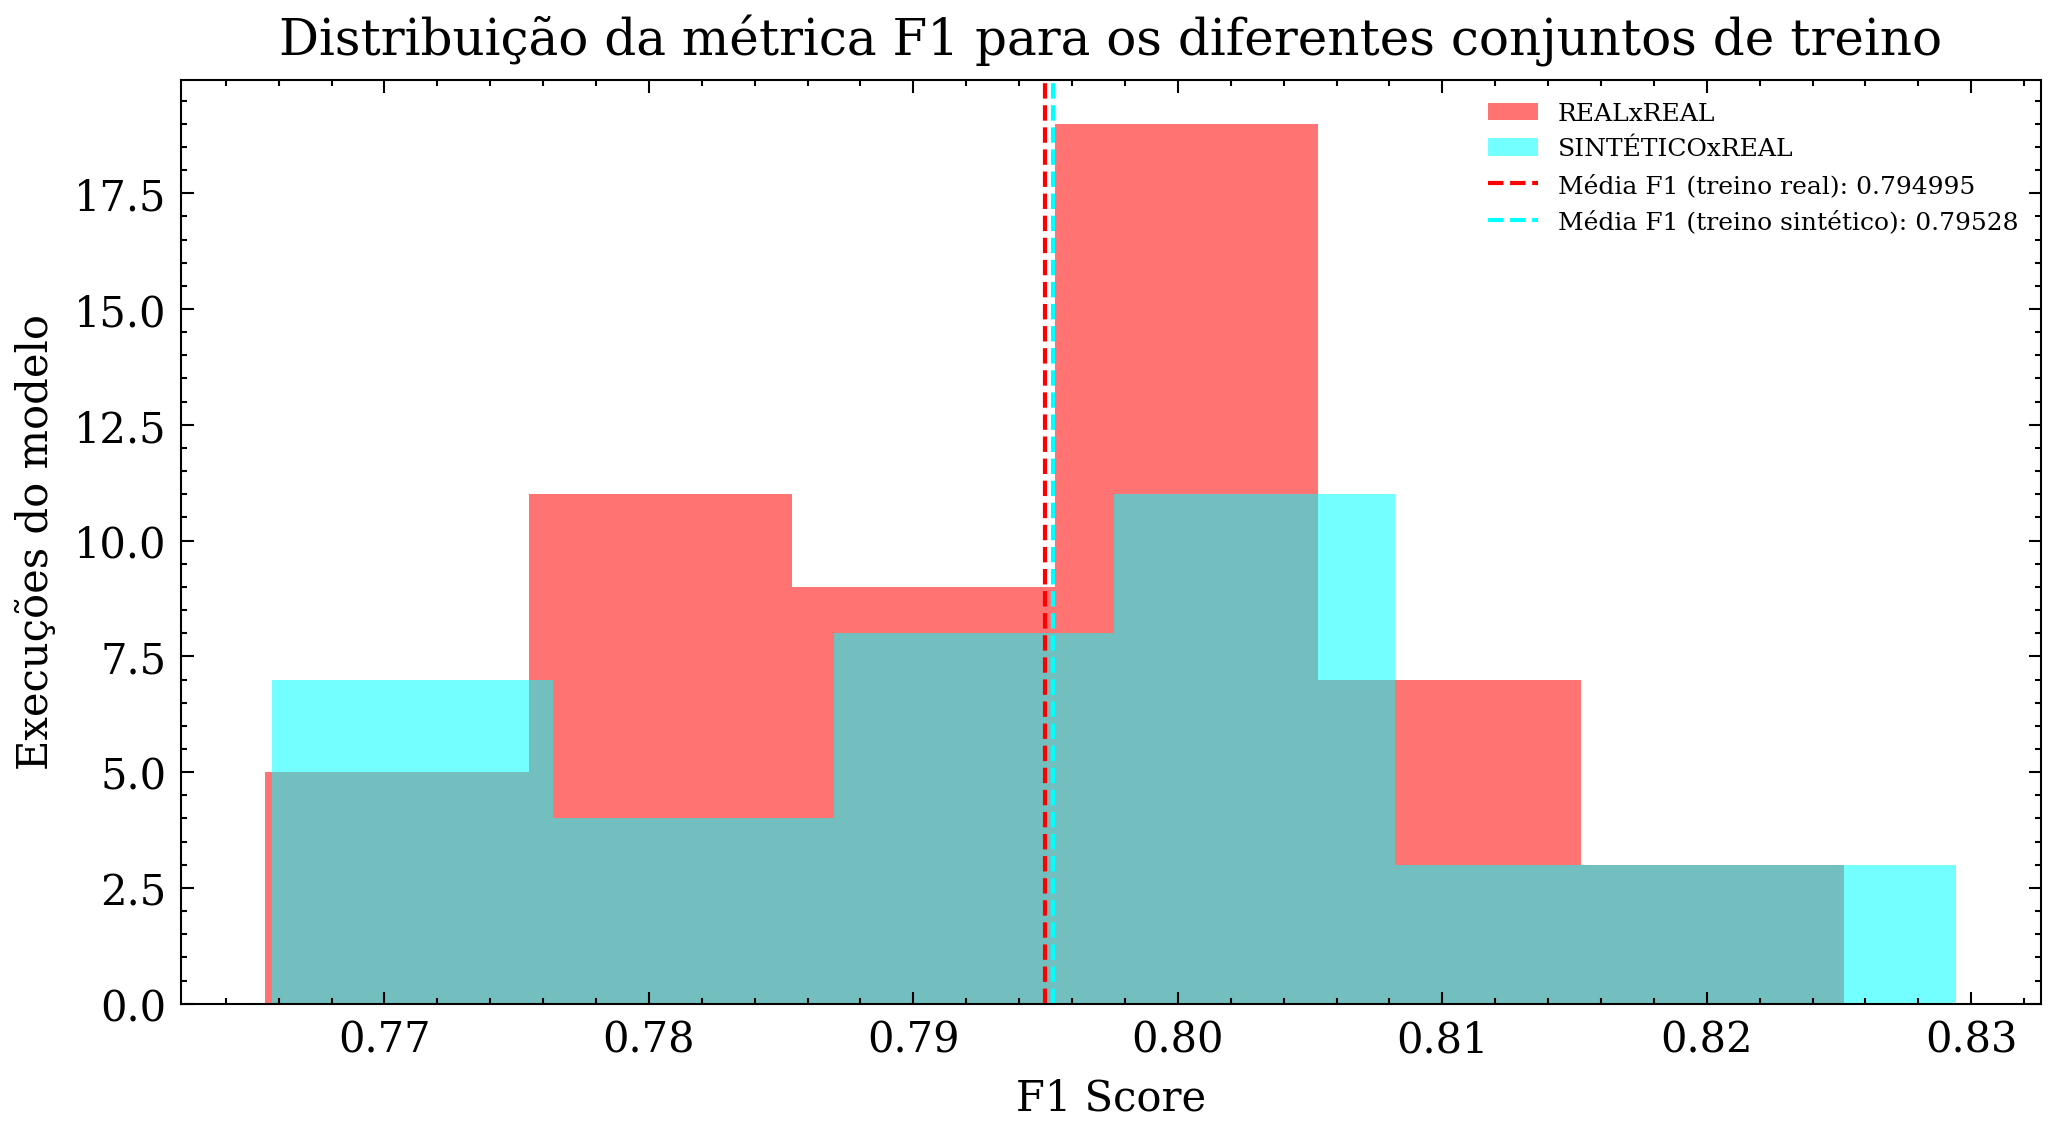

In [14]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=(300))

runs_reais = sigma_clip(rdf[rdf.experiment_name == "XRAY-64x64-REAL"].f1, sigma=3, cenfunc="mean", masked=False)
runs_sinteticas = sigma_clip(rdf[rdf.experiment_name == "XRAY-64x64-SYNTHETIC-UNBALANCED"].f1, sigma=3, cenfunc="mean", masked=False)

hist(
    runs_reais,
    histtype='stepfilled',
    bins="knuth",
    alpha=.55,
    ax=ax,
    color='red',
    label="REALxREAL"
)
hist(
    runs_sinteticas,
    histtype='stepfilled',
    bins="knuth",
    alpha=.55,
    ax=ax,
    color='cyan',
    label="SINTÉTICOxREAL",
)

ax.set_xlabel("F1 Score")
ax.set_ylabel("Execuções do modelo")

ax.axvline(runs_reais.mean(), color='red', linestyle='--', label=f"Média F1 (treino real): {round(runs_reais.mean(), 6)}")
ax.axvline(runs_sinteticas.mean(), color='cyan', linestyle='--', label=f"Média F1 (treino sintético): {round(runs_sinteticas.mean(), 6)}")

ax.set_title("Distribuição da métrica F1 para os diferentes conjuntos de treino")

plt.legend(prop={"size": 6})
plt.savefig("f1.png")

In [15]:
from statsmodels.stats.weightstats import ttest_ind

In [16]:
tstat, p, dof = ttest_ind(runs_reais, runs_sinteticas, value=0)

print(f"p-value: {p}")

p-value: 0.9291862025326544


---

# Tempo de convergência

Plotar gráfico de convergência selecionando aleatoriamente 10 runs de cada conjunto de treino diferente

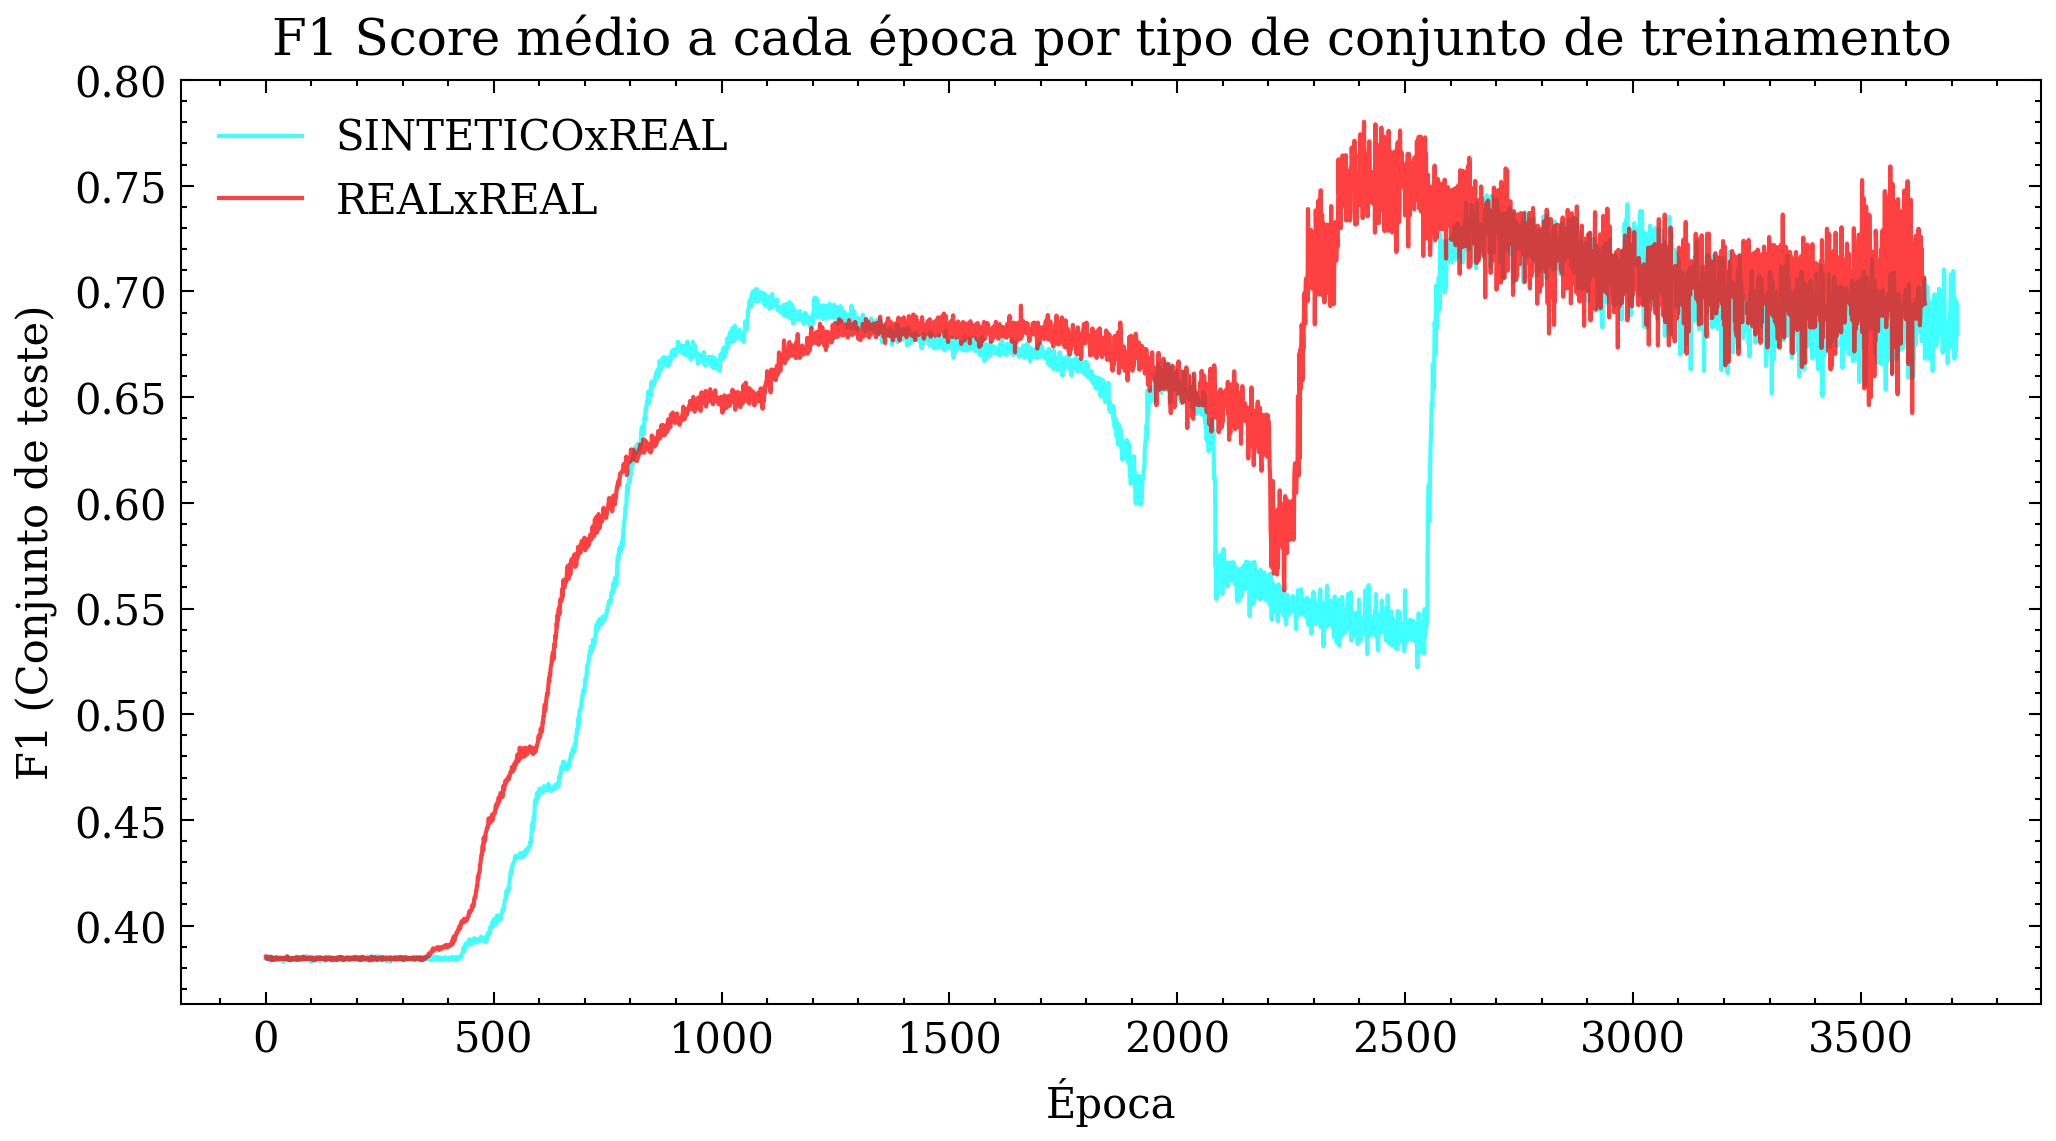

In [17]:
cdf = df.groupby(["experiment_name", "step"]).agg({"f1_macro_test": "mean"}).reset_index()
fig, ax = plt.subplots(figsize=(8, 4), dpi=(300))
sns.lineplot(data=cdf[cdf.experiment_name=="XRAY-64x64-SYNTHETIC-UNBALANCED"], x="step", y="f1_macro_test", label="SINTETICOxREAL", color='cyan', alpha=.75)
sns.lineplot(data=cdf[cdf.experiment_name=="XRAY-64x64-REAL"], x="step", y="f1_macro_test", label="REALxREAL", color='red', alpha=.75)
ax.set_title("F1 Score médio a cada época por tipo de conjunto de treinamento")
ax.set_xlabel("Época")
ax.set_ylabel("F1 (Conjunto de teste)")
plt.show()

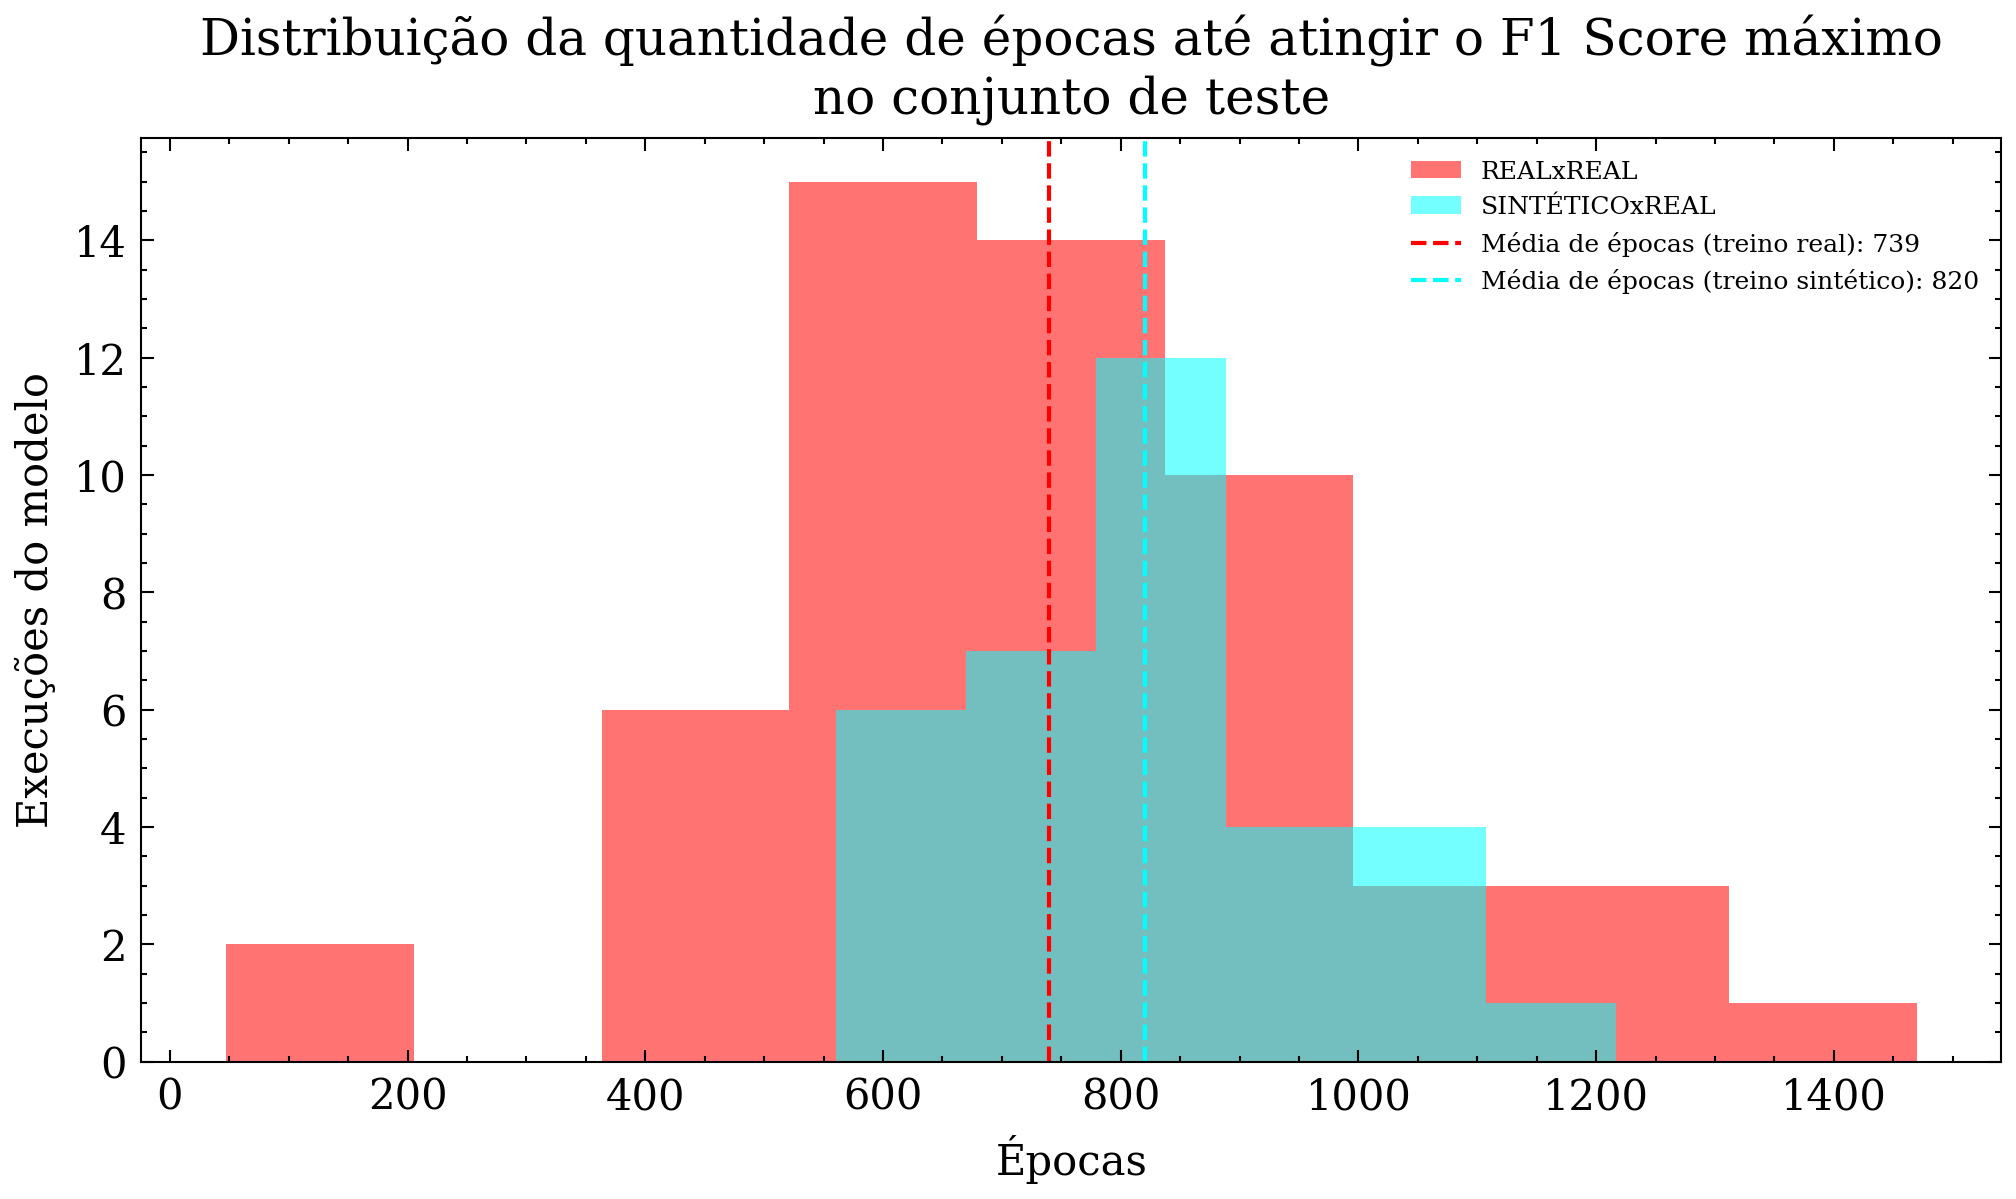

In [18]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=(300))

runs_reais = sigma_clip(rdf[rdf.experiment_name == "XRAY-64x64-REAL"].converge_at, sigma=3, cenfunc="mean", masked=False)
runs_sinteticas = sigma_clip(rdf[rdf.experiment_name == "XRAY-64x64-SYNTHETIC-UNBALANCED"].converge_at, sigma=3, cenfunc="mean", masked=False)

hist(
    runs_reais,
    histtype='stepfilled',
    bins="freedman",
    alpha=.55,
    ax=ax,
    color='red',
    label="REALxREAL"
)
hist(
    runs_sinteticas,
    histtype='stepfilled',
    bins="freedman",
    alpha=.55,
    ax=ax,
    color='cyan',
    label="SINTÉTICOxREAL",
)

ax.set_xlabel("Épocas")
ax.set_ylabel("Execuções do modelo")

ax.axvline(runs_reais.mean(), color='red', linestyle='--', label=f"Média de épocas (treino real): {round(runs_reais.mean())}")
ax.axvline(runs_sinteticas.mean(), color='cyan', linestyle='--', label=f"Média de épocas (treino sintético): {round(runs_sinteticas.mean())}")

ax.set_title("Distribuição da quantidade de épocas até atingir o F1 Score máximo\nno conjunto de teste")

plt.legend(prop={"size": 6})
plt.savefig("epochs.png")